UPD:<br>
Now the images are more readable and I added more explanations on spectrograms!

# Introduction to research

HMS-HBAC competition contains two kinds of data: raw EEG and ready-to-use base spectrograms. Approach with base spectrograms gives a good LB score but has low flexibility because of difficult tuning of existing spectogram. For example, we cannot change window type or window size and see results. In this research I will try to explain main features of Short-time Fourier Transform (STFT) and spectrograms and show their advantages and disadvantages.

# Brief explanation of STFT

From a practical point of view, Short-time Fourier Transform (STFT) is a kind of Fourier Transform which allows us to see signal in time-frequency domain, unlike usual Fast Fourier Transform (FFT), which allows to see the whole signal only in frequency domain. It is very useful when we want to see signal frequency response in particular moment of time or signal has non-stationary frequency in time domain.<br>
I will skip low-level mathematical explanation of STFT and begin right from high-level STFT features.<br>

The main feature of STFT is usage of overlapping (not necessary, but usually) subsets of samples from entire signal, when FFT uses entire signal. Exactly this feature allows us to transform signal to time-frequency domain. <br>
The second feature of STFT is window functions. Window functions are needed to attenuate border effects. What are border effects? In simple explanation, border effects are spectrum artifacts caused by discontinuites at rectangular window bounds. Rectangular window comes from FFT and works fine because of usage on full signal but gives bad results when used on subsets of signal.<br>

Here you can see a good graphical explanation of difference between FFT and STFT.<br>
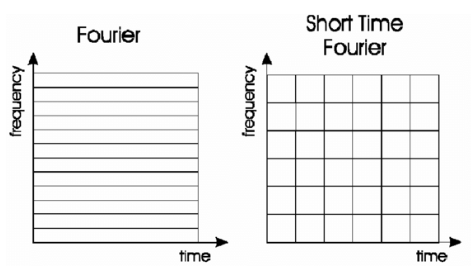

However, STFT isn't a panacea. It has disadvantages, which will be shown a bit later. 

# Library installation and import

I will use a newer scipy version because of more flexible API for STFT

In [ ]:
# We need a newer version of scipy for this notebook
!pip install --upgrade --no-deps scipy

In [ ]:
import numpy as np
import pandas as pd

# Most popular window in STFT is Hann
from scipy.signal.windows import hann
from scipy.signal import ShortTimeFFT

import os

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Global variables

In [ ]:
Fs = 200
Ts = 1/Fs

# Data loading

In [ ]:
DATA_DIR = '/kaggle/input/hms-harmful-brain-activity-classification'

METADATA_PATH = os.path.join(DATA_DIR, 'train.csv')

EEGS_PATH = os.path.join(DATA_DIR, 'train_eegs')
SPECTROGRAMS_PATH = os.path.join(DATA_DIR, 'train_spectrograms')

In [ ]:
df_metadata = pd.read_csv(METADATA_PATH)
df_metadata.head(10)

In [ ]:
row_num = 1
eeg_id = df_metadata['eeg_id'].iloc[row_num]
spectrogram_id = df_metadata['spectrogram_id'].iloc[row_num]

In [ ]:
EEG_SAMPLE_FILE = os.path.join(EEGS_PATH, f'{eeg_id}.parquet')
SPECTROGRAM_SAMPLE_FILE = os.path.join(SPECTROGRAMS_PATH, f'{spectrogram_id}.parquet')

In [ ]:
df_eeg = pd.read_parquet(EEG_SAMPLE_FILE)
df_eeg.head(10)

In [ ]:
df_spectrogram = pd.read_parquet(SPECTROGRAM_SAMPLE_FILE)
df_spectrogram.head(10)

I will use Fp1 channel and LL electrode chain from 10-20 montage for drawing. Drawings for 10-20 montage you can see below.

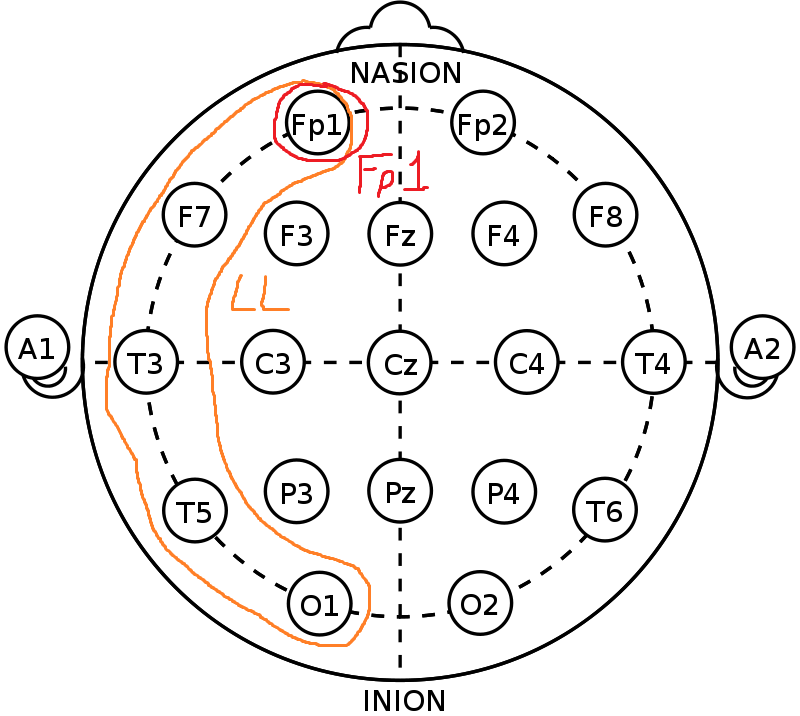]

# Plot raw EEG data and spectograms

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), layout='compressed')

xticks = np.arange(0, Ts*len(df_eeg), 5)

ax[0].plot(np.arange(start=0, stop=Ts*len(df_eeg), step=Ts), df_eeg['Fp1'])
ax[0].set_title('Fp1 channel data')
ax[0].set_xlabel('Time, s')
ax[0].set_ylabel('Signal, $ \mu $V')
ax[0].set_xticks(xticks)
ax[0].set_xlim((0, Ts*len(df_eeg)))

LL_cols = list(df_spectrogram.filter(regex=("LL_*")).columns)
LL_freqs = [float(x.split('_')[-1]) for x in LL_cols]
extent = (min(df_spectrogram['time']), max(df_spectrogram['time']), min(LL_freqs), max(LL_freqs))
pos = ax[1].imshow(df_spectrogram[LL_cols].to_numpy().T, extent=extent, aspect='auto', origin='lower')
ax[1].set_title('LL chain spectrogram')
ax[1].set_xlabel('Time, s')
ax[1].set_ylabel('Frequency, Hz')
cb = fig.colorbar(pos)
cb.ax.set_ylabel('Amplitude, $\mu$V')

We can see that signal has the highest amplitudes on frequencies between 2 and 3 Hz. Let's build our own spectrograms and look closer on it's characteristics.

# Custom spectrograms

In our research I will use STFT with Hann window. You can see it's form and frequency response below.

In [ ]:
window_len = 1024
hann_window = hann(window_len)
sfft_hann = ShortTimeFFT(win=hann_window, hop=32, fs=Fs)
plt.plot(sfft_hann.win)
plt.title('Hann window')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')

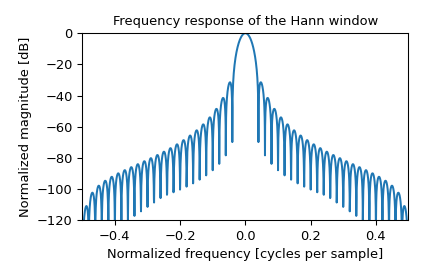

In [ ]:
#Demean data to remove DC bias
fp1_data = df_eeg['Fp1'].to_numpy()
fp1_data = fp1_data - np.nanmean(fp1_data)

What's next?
STFT has different parameters to tune. The most important are window length and length of FFT (called as mfft in scipy).<br>
Window length is used to change time and frequency resolution. mfft is needed if you want to make FFT length larger than window length. Samples outside the window are treated as 0 (zero-padded FFT). It is useful when you have only a few points but want to increase frequency resolution. <br>
Next parameter is hop or sample increment for sliding window. Hop is used to regulate the window time step.<br>

In [ ]:
win_sizes = (32, 64, 128, 256, 512, 1024)

fig, ax = plt.subplots(len(win_sizes), len(hops), figsize=(20, 17), layout='compressed')

win_counter = 0
for window_len in win_sizes:
    hann_window = hann(window_len)
    mfft = 2*(window_len)
    hop = window_len//10
    sfft_hann = ShortTimeFFT(win=hann_window, hop=hop, fs=Fs, mfft=mfft)
    Sx_hann = abs(sfft_hann.stft(fp1_data))
    max_freq = 20
    max_freq_idx = int(max_freq//sfft_hann.delta_f)
    Sx_hann = Sx_hann[:max_freq_idx, :]
    df = sfft_hann.delta_f
    dt = sfft_hann.delta_t
    yticks = np.arange(0, max_freq, 5)
    xticks = np.arange(0, max(sfft_hann.t(len(fp1_data))), 5)
    extent = (min(xticks), max(xticks), min(yticks), max(yticks))
    pos = ax[win_counter].imshow(Sx_hann, extent=extent, aspect='auto', origin='lower', cmap='jet')
    ax[win_counter].set_title(f'{window_len} window length, mfft {mfft} spectrogram')
    ax[win_counter].set_xlabel('Time, s')
    ax[win_counter].set_ylabel('Frequency, Hz')
    ax[win_counter].set_yticks(yticks)
    ax[win_counter].set_xticks(xticks)
    cb = fig.colorbar(pos)
    cb.ax.set_ylabel('Amplitude, $\mu$V')
    win_counter += 1

In [ ]:
win_sizes = (32, 64, 256, 512, 1024)

fig, ax = plt.subplots(1, len(win_sizes), figsize=(20, 20), layout='compressed', subplot_kw={"projection": "3d"})

dt_list = []
df_list = []

counter = 0
for window_len in win_sizes:
    hann_window = hann(window_len)
    mfft = 2*(window_len)
    hop = window_len//10
    sfft_hann = ShortTimeFFT(win=hann_window, hop=hop, fs=Fs, mfft=mfft)
    Sx_hann = abs(sfft_hann.stft(fp1_data))
    df = sfft_hann.delta_f
    dt = sfft_hann.delta_t
    dt_list.append(dt)
    df_list.append(df)
    x = sfft_hann.t(len(fp1_data))
    y = sfft_hann.f
    x, y = np.meshgrid(x, y)
    #surf = ax[counter].plot_surface(x, y, Sx_hann, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    surf = ax[counter].plot_surface(x, y, Sx_hann)
    ax[counter].set_title(f'{window_len} window length spectrogram')
    ax[counter].set_xlabel('Time, s')
    ax[counter].set_ylabel('Frequency, Hz')
    ax[counter].set_zlabel('PSD')
    #ax[counter].set_yticks(yticks)
    #ax[counter].set_xticks(xticks)
    cb = fig.colorbar(pos)
    cb.ax.set_ylabel('Amplitude, $\mu$V')
    counter += 1

We can see that frequency resolution gets higher with window size. But time resolution simultaneously gets worse. Such effect is a consequense of [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle). It is the main disadvantage of STFT. Let me illustrate it on simple example.

In [ ]:
Fs = 1e6
Ts = 1/Fs

time_samples = np.arange(0, 0.1+Ts, Ts)
signal = np.zeros(len(time_samples))
signal

In [ ]:
for i in range(len(signal)):
    if i < len(signal)//4:
        signal[i] = np.sin(2*np.pi*300*time_samples[i])
    if i >= len(signal)//4*1 and i < len(signal)//4*2:
        signal[i] = np.sin(2*np.pi*200*time_samples[i])
    if i >= len(signal)//4*2 and i < len(signal)//4*3:
        signal[i] = np.sin(2*np.pi*100*time_samples[i])
    if i >= len(signal)//4*3:
        signal[i] = np.sin(2*np.pi*50*time_samples[i])

In [ ]:
win_sizes = (16384, 32768, 65536)
max_freq = 400
fig, ax = plt.subplots(1, len(win_sizes), figsize=(20, 20), layout='compressed', subplot_kw={"projection": "3d"})

counter_win = 0
for window_len in win_sizes:
    hann_window = hann(window_len)
    hop = window_len//10
    mfft = 2*window_len
    sfft_hann = ShortTimeFFT(win=hann_window, hop=hop, fs=Fs, mfft=mfft)
    Sx_hann = abs(sfft_hann.stft(signal))
    df = sfft_hann.delta_f
    dt = sfft_hann.delta_t
    print(f'Freq step {df}, time step {dt}, win size {window_len}, hop {hop}')
    x = sfft_hann.t(len(signal))
    y = sfft_hann.f[:int(max_freq/df)]
    x, y = np.meshgrid(x, y)
    #surf = ax[counter].plot_surface(x, y, Sx_hann, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    surf = ax[counter_win].plot_surface(y, x, Sx_hann[:int(max_freq/df), :], cmap=cm.coolwarm)
    ax[counter_win].set_title(f'{window_len} window length, {mfft} mfft spectrogram')
    ax[counter_win].set_ylabel('Time, s')
    ax[counter_win].set_xlabel('Frequency, Hz')
    ax[counter_win].set_zlabel('PSD')
    #ax[counter].set_yticks(yticks)
    #ax[counter].set_xticks(xticks)
    cb = fig.colorbar(pos)
    cb.ax.set_ylabel('Amplitude, $\mu$V')
    counter_win += 1

What we can see?<br>
Time step depends on hop value. In this example it is not so critical because of high sample rate and large number of samples.<br>
Higher window length gives tighter peaks for frequency but wider for time - resolution becomes more inaccurate in time domain.<br>


# Small conclusion

The main conclusion is that STFT needs accurate tuning to represent correct time-frequency resolution of signal and improve LB score.<br>
You can change 4 parameters - window, window length, FFT length and hop. <br>
1. Be accurate when choosing window - take a look at it's frequency response, it is important to suppress the border effect. <br>
2. Window length can completely change the situation because time and frequency resolution completely depends on it. <br>
3. FFT length is useful when you need to lower the frequency step but can be harmful for data quality when wrong value is chosen. <br>
4. Hop changes time step and as a consequence, the length of spectrogram. But very large hop lowers data quality.